In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import minmax_scale
from sklearn.impute import SimpleImputer
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import netCDF4 as nc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from cartopy import crs as ccrs
import matplotlib.cm as cm
from matplotlib.colors import Normalize


In [18]:
class ClusterAnalysis:
    def __init__(self, nc_file, district_shapefile,noc,title):
        
        self.nc_file = nc_file
        self.district_shapefile = district_shapefile
        self.noc = noc
        self.title = title
        
    def preprocessing(self):
        
        data = nc.Dataset(self.nc_file)
        variable_names = list(data.variables.keys())
        latitude = data.variables[variable_names[2]][:]
        longitude = data.variables[variable_names[3]][:]
        time_var = data.variables['time']
        
        try:
            time_units = time_var.units
            time_calendar = getattr(time_var, 'calendar', 'standard')
            time = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
            time = np.array(time, dtype='datetime64[ns]')
            time = pd.to_datetime(time)
            
        except AttributeError:
            
            time = pd.to_datetime(time_var[:], unit='s', origin='unix')
        
        variable = np.array(data.variables[variable_names[0]][:, :, :])
        
        if variable_names[0] =='tp':
            variable = variable*8640
            low = 0
            high = 29
        
        elif variable_names[0] == 't2m':
            variable = variable - 273
            low,high = 20,40
       
        else:
            variable = variable
            low,high = 0,100
            pass
        
        imputer = SimpleImputer(strategy='mean')
        variable_reshaped = variable.reshape(variable.shape[0],-1)
        variable_reshaped = imputer.fit_transform(variable_reshaped)
        scaler = MinMaxScaler()
        variable_ = scaler.fit_transform(variable_reshaped)
        return variable,variable_,latitude,longitude,time,low,high
        

    def train_som(self,scaled_rain,sigma,lr):
        som_shape = (self.noc, self.noc)
        som = MiniSom(som_shape[0], som_shape[1], scaled_rain.shape[1], sigma=sigma, learning_rate=lr,
                      neighborhood_function='gaussian', random_seed=10)
        
        max_iter = 500
        q_error = []
        t_error = []
        
        for i in range(max_iter):
            rand_i = np.random.randint(len(scaled_rain))
            som.update(scaled_rain[rand_i], som.winner(scaled_rain[rand_i]), i, max_iter)
            q_error.append(som.quantization_error(scaled_rain))
            t_error.append(som.topographic_error(scaled_rain))
        
        plt.plot(np.arange(max_iter), q_error, label='quantization error')
        plt.plot(np.arange(max_iter), t_error, label='topographic error')
        plt.ylabel('Quantization error')
        plt.xlabel('Iteration index')
        plt.legend()
        plt.show()
        return som

    def k_means_Clustering(self,scaled_features, n_clusters,data):
        kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=20, max_iter=20, random_state=0)
        kmeans.fit(scaled_features)
        labels = kmeans.labels_
    
        avg_clusters = []
        cluster_indices = []
    
        for i in range(n_clusters):
            cluster_indices.append(np.where(labels == i))
            cluster_data = data[cluster_indices[i]]
            avg_cluster = cluster_data.mean(axis=0)
            avg_clusters.append(avg_cluster)
    
        return avg_clusters, cluster_indices


    def clusters(self,model,data):
        cluster_assignments = np.array([model.winner(d) for d in data])
        cluster_indices = []
        unique_clusters = np.unique(cluster_assignments, axis=0)
        for cluster in unique_clusters:
            indices = np.where(np.all(cluster_assignments == cluster, axis=1))[0]
            cluster_indices.append(indices)
        return cluster_indices

    def findseason(self,cluster_indices,time):
        fig, axs = plt.subplots(2, 2, figsize=(8, 5))  # 3 rows, 3 columns
    
        for idx, indices in enumerate(cluster_indices):
            months = (time[indices]).month
            unique_months, month_counts = np.unique(months, return_counts=True)
    
            
            row = idx // 2  
            col = idx % 2  
            ax = axs[row, col]
    
            ax.hist(months, bins=np.arange(1, 14) - 0.5, rwidth=0.8, edgecolor='black')
            ax.set_xlabel('Month')
            ax.set_ylabel('Frequency')
            ax.set_title(f'precipitation - Cluster {idx+1}')
            ax.set_xticks(np.arange(1, 13))
            ax.grid(axis='y', linestyle='--', alpha=0.7)
    
        plt.tight_layout()
        plt.show()

    def cluster_and_average(self,cluster_indices, n_clusters, data):
        avg_clusters = []
        for i in range(n_clusters):
            cluster_data = data[cluster_indices[i]]
            avg_cluster = cluster_data.mean(axis=0)
            avg_clusters.append(avg_cluster)
    
        return avg_clusters

    def plot_clusters(self,avg_clusters,low,high,lon,lat):
        lon_lat_crs = ccrs.PlateCarree()
        cmap=cm.get_cmap('jet')
        normalizer=Normalize(low,high)
        im0=cm.ScalarMappable(norm=normalizer,cmap=cmap)
        num_clusters = len(avg_clusters)
        num_rows = (num_clusters + 2) // 3  
    
        
        fig, axs = plt.subplots(num_rows, 2, figsize=(18, 8 * num_rows), subplot_kw={'projection': lon_lat_crs})
    
        
        titles = [f'C {i+1}' for i in range(num_clusters)]
    
        
        districts = gpd.read_file(self.district_shapefile)  
        districts = districts.to_crs(lon_lat_crs.proj4_init)  
    
        # Loop through each subplot
        for i, ax in enumerate(axs.flat):
            if i < num_clusters:
                im = ax.contourf(lon, lat, avg_clusters[i], 20, transform=lon_lat_crs, cmap='jet', clim=(low,high))
                ax.coastlines()
                
    
                # Plot district boundaries
                districts.boundary.plot(ax=ax, color='white', linewidth=1)  # Adjust color and linewidth as needed
    
                ax.set_title(f'{self.title} - {titles[i]}')
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
    
                # Add colorbar
                cbar = plt.colorbar(im, ax=ax, shrink=1)
                cbar.set_label(f'{self.title}')
            else:
                # If there are empty subplots, remove them
                fig.delaxes(ax)
    
        # Adjust layout to prevent overlapping
        plt.tight_layout()
    
        # Show the plot
        plt.show()

    

    def plot_same_clusters(self,avg_clusters,low,high,lon,lat):
        lon_lat_crs = ccrs.PlateCarree()
        cmap=cm.get_cmap('jet')
        normalizer=Normalize(low,high)
        im0=cm.ScalarMappable(norm=normalizer,cmap=cmap)
        num_clusters = len(avg_clusters)
        num_rows = (num_clusters + 2) // 3 
        fig, axs = plt.subplots(num_rows, 2, figsize=(8, 7 ), subplot_kw={'projection': lon_lat_crs})
    
        # Titles for each subplot
        titles = [f'C {i+1}' for i in range(num_clusters)]
    
        # Load and reproject district boundaries
        districts = gpd.read_file(self.district_shapefile)  # Load district boundaries
        districts = districts.to_crs(lon_lat_crs.proj4_init)  # Reproject to lon/lat CRS
    
        # Loop through each subplot
        for i, ax in enumerate(axs.flat):
            if i < num_clusters:
                im = ax.contourf(lon, lat, avg_clusters[i], 20, transform=lon_lat_crs, cmap='jet', norm=normalizer)#, vmin=vmin, vmax=vmax)
                ax.coastlines()
                #im.set_clim(vmin, vmax)
    
                # Plot district boundaries
                districts.boundary.plot(ax=ax, color='black', linewidth=1)  # Adjust color and linewidth as needed
    
                ax.set_title(f'{self.title} - {titles[i]}')
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
    
                
            
            else:
                # If there are empty subplots, remove them
                fig.delaxes(ax)
                
        cbar = fig.add_axes([0.1, 0.05, 0.8, 0.04])
        fig.colorbar(im0, cax=cbar, shrink=0.9, orientation='horizontal')
        cbar.set_label(f'{self.title}')
    
        # Adjust layout to prevent overlapping
        #plt.tight_layout()
    
        # Show the plot
        plt.show()
    
    


    def anlize(self):
        data_3D,var,lat,lon,time,low,high = self.preprocessing()
        som_model = self.train_som(var,1,1)
        c_indices = self.clusters(som_model,var)
        c_averages = self.cluster_and_average(c_indices, 4, data_3D)
        K_means_avg_clusters, k_means_cluster_indices = self.k_means_Clustering(var,4, data_3D)
        self.findseason(c_indices,time)
        self.plot_clusters(c_averages,low,high,lon,lat)
        self.plot_same_clusters(c_averages,low,high,lon,lat)
        print("=" * 100)
        print("plots_for_K-Means")
        self.findseason(k_means_cluster_indices,time)
        self.plot_clusters(K_means_avg_clusters,low,high,lon,lat)
        self.plot_same_clusters(K_means_avg_clusters,low,high,lon,lat)
        

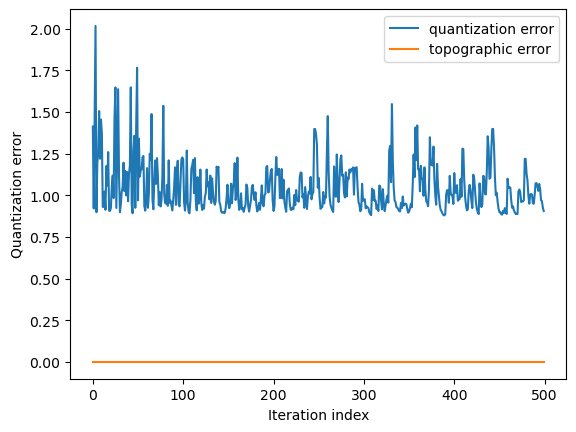

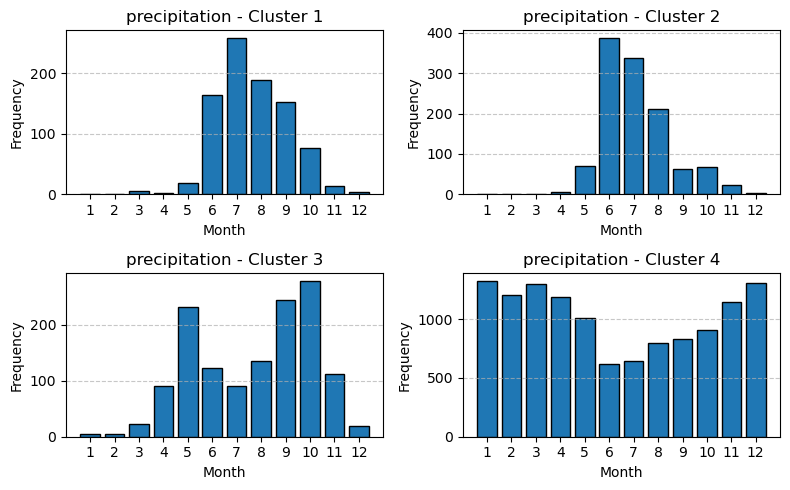

/tmp/ipykernel_2719830/1071221745.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet')
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'cl

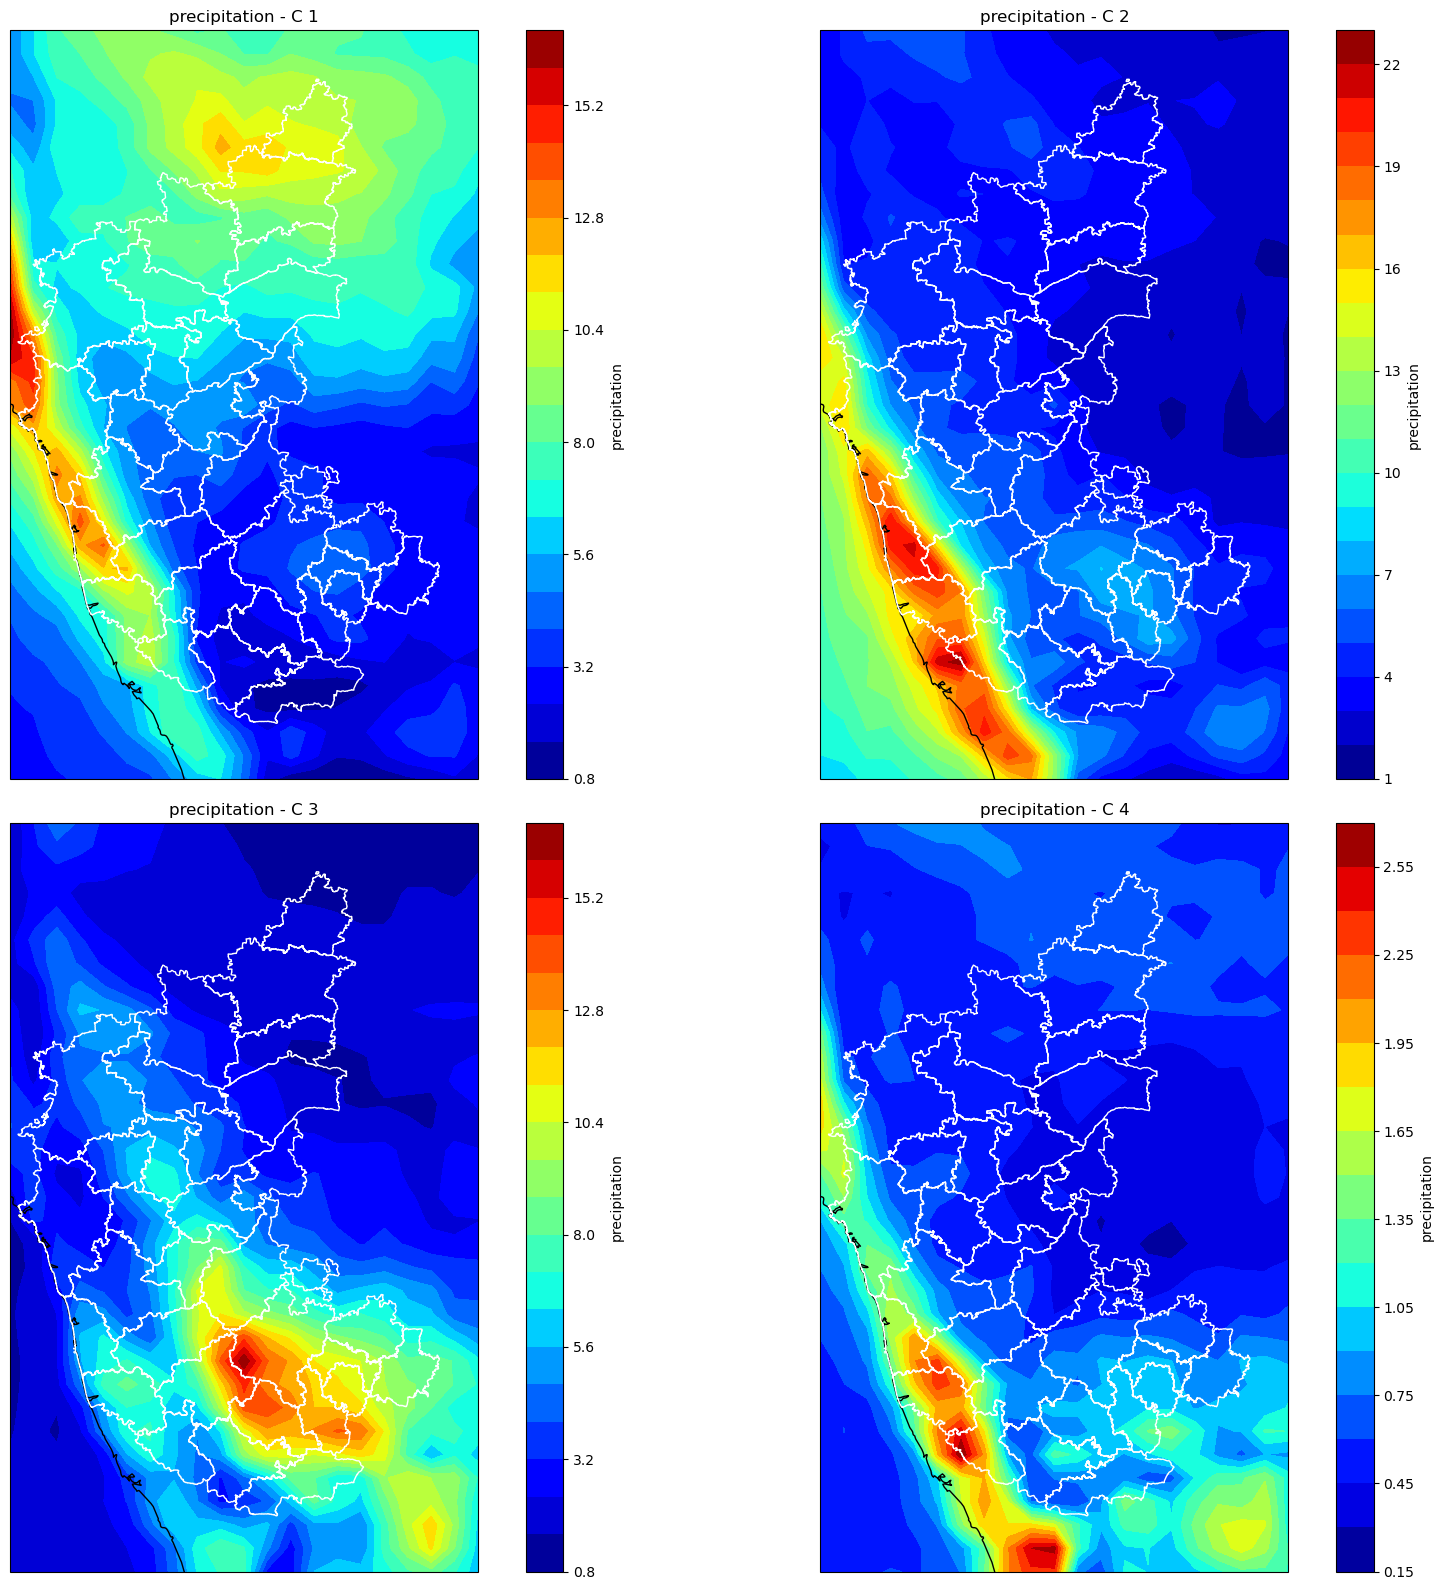

/tmp/ipykernel_2719830/1071221745.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet')


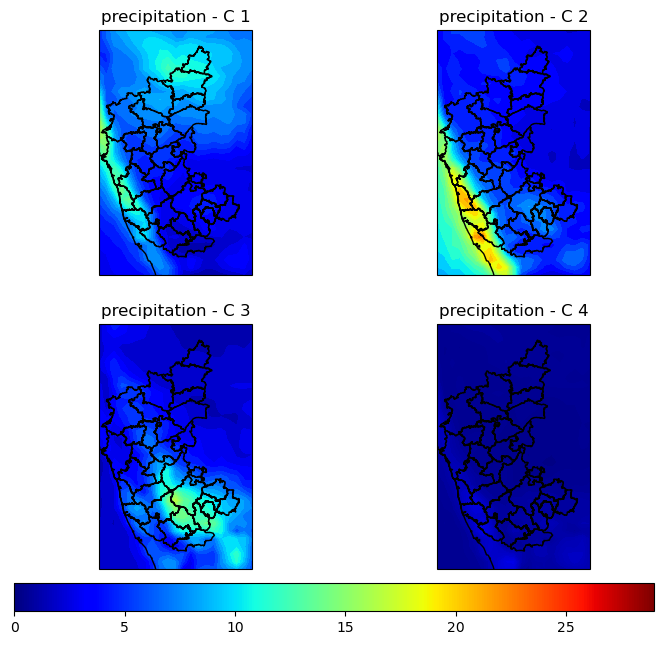

plots_for_K-Means


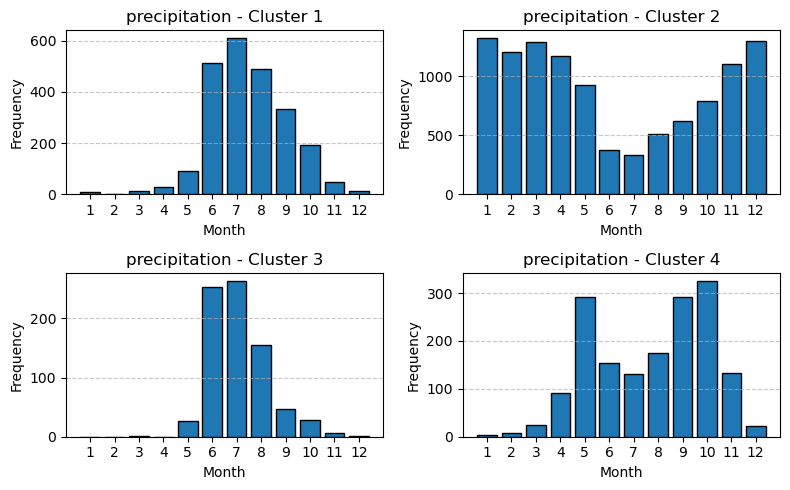

/tmp/ipykernel_2719830/1071221745.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet')
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'cl

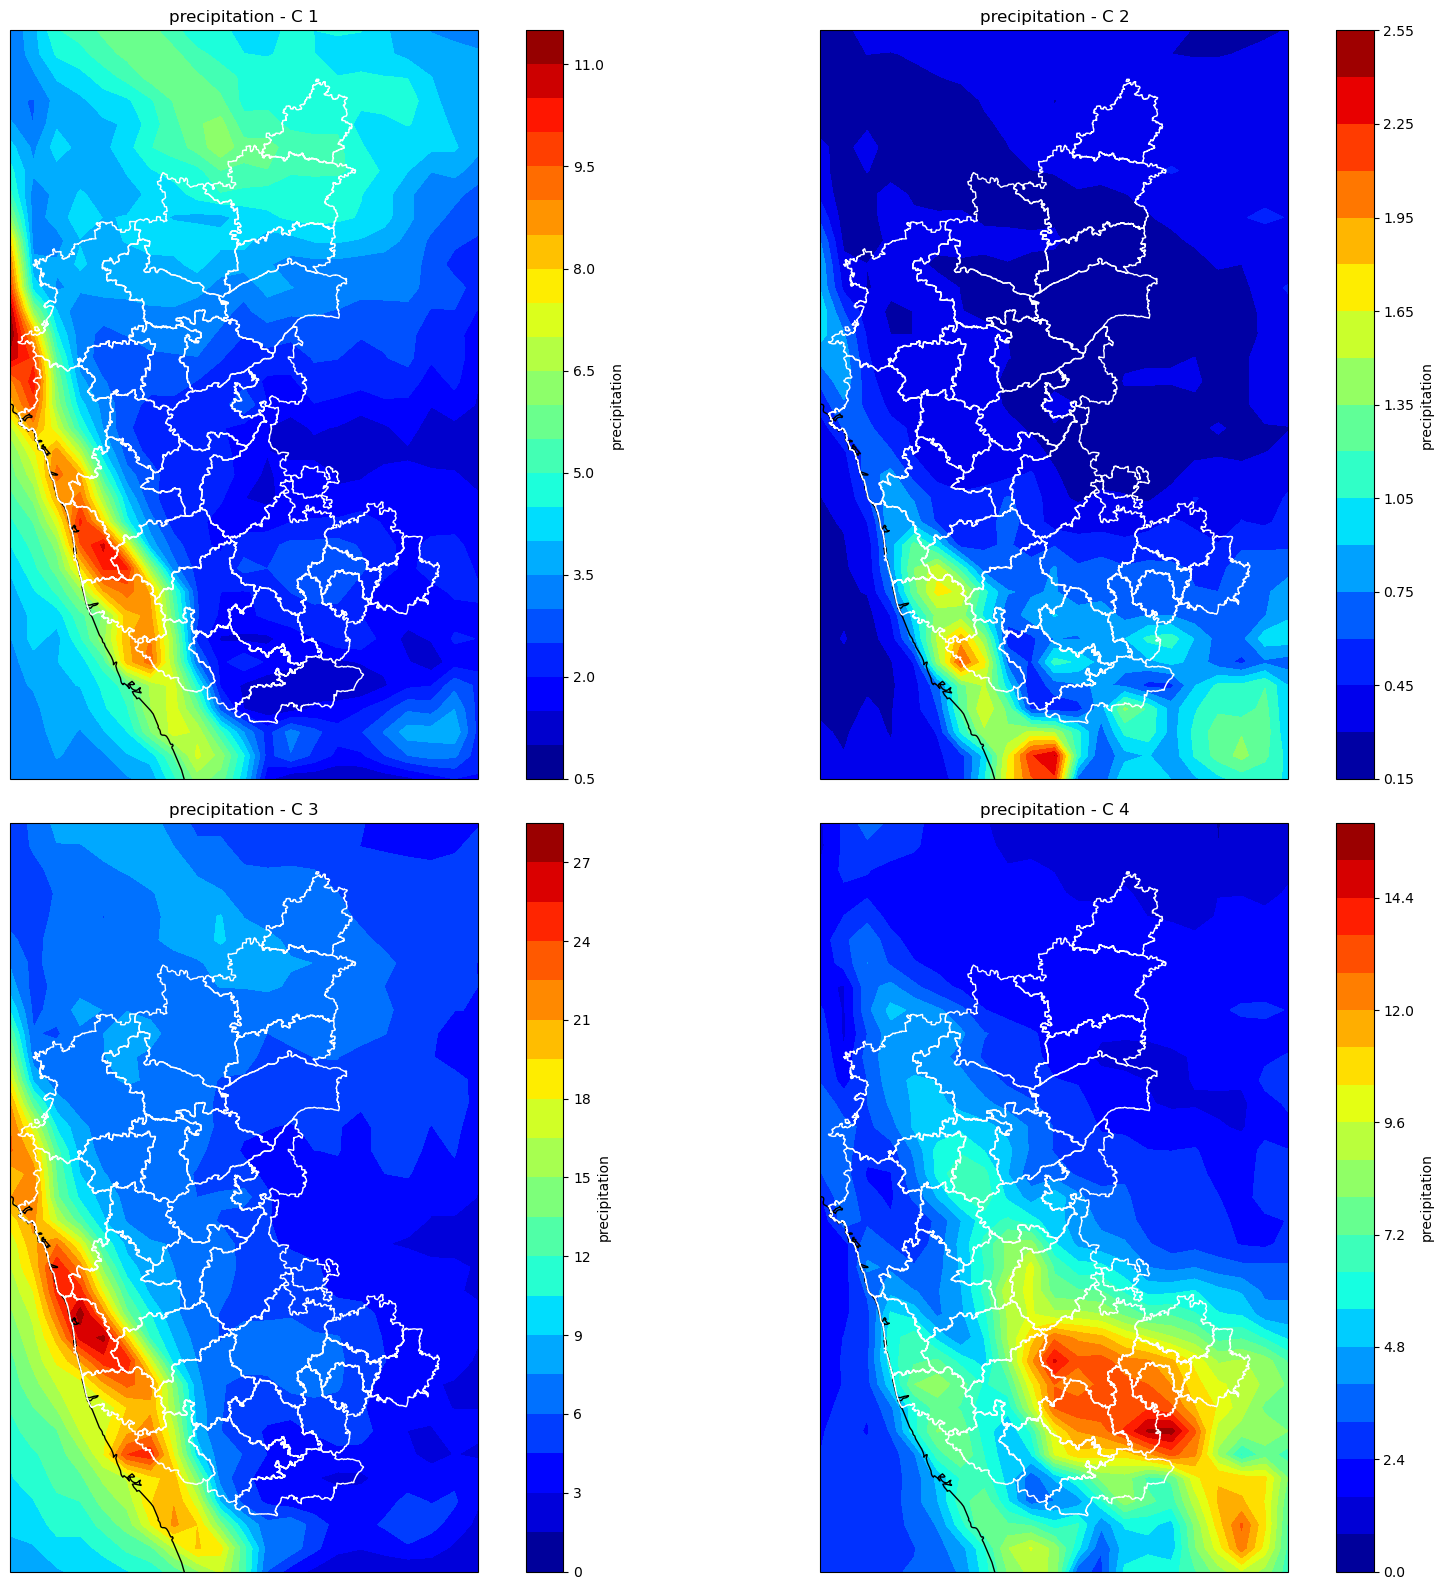

/tmp/ipykernel_2719830/1071221745.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet')


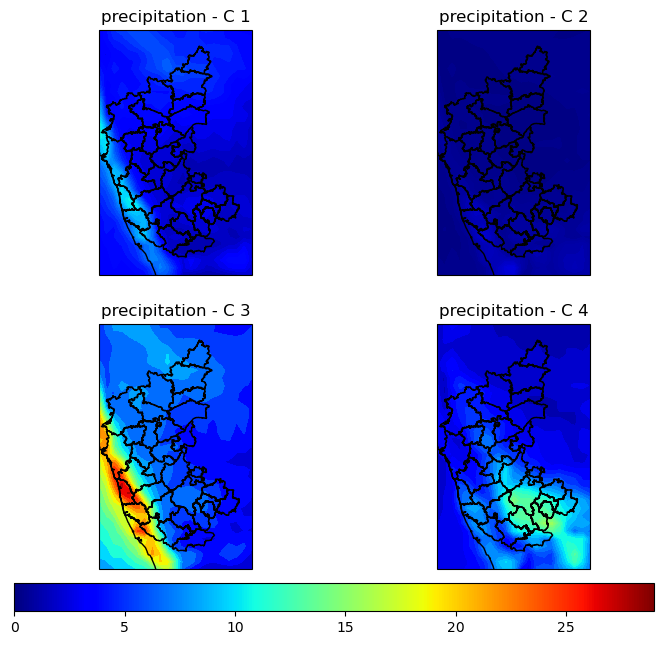

In [19]:
cluster_analysis = ClusterAnalysis("merged_rainfall.nc",'District.shp',2,'precipitation')
cluster_analysis.anlize()